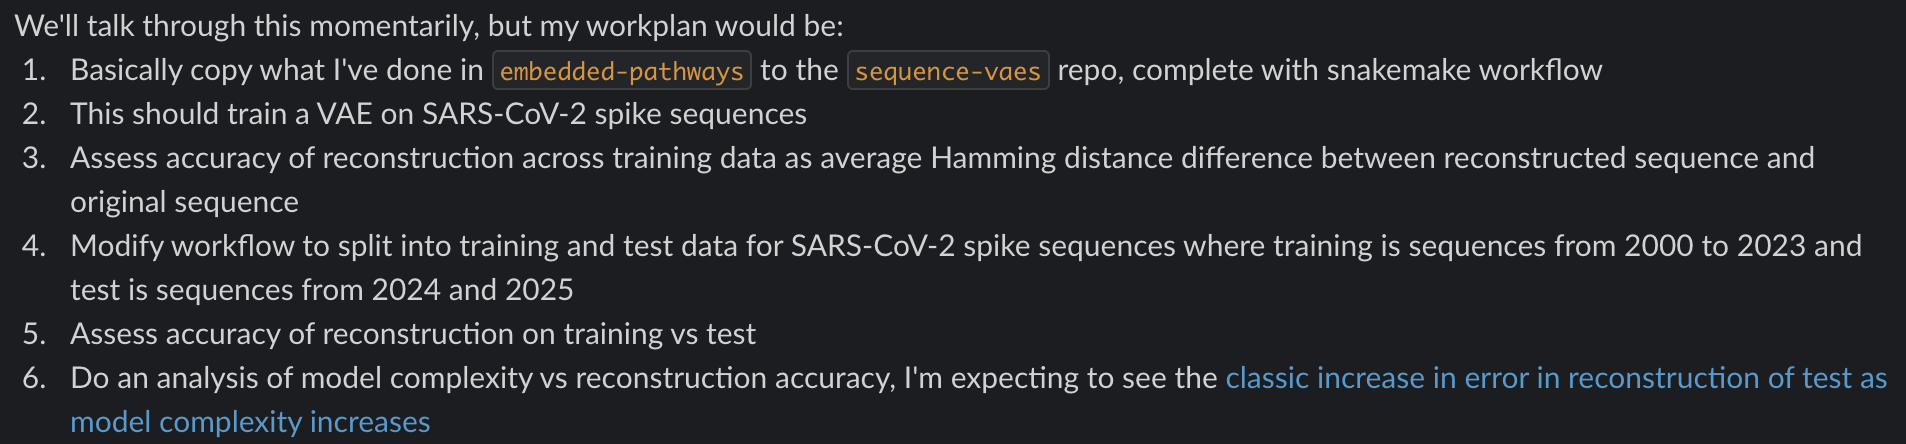

In [1]:
# from google.colab import drive
# drive.mount("/content/drive", force_remount=True)

In [2]:
# path to sequence_vaes directory
# abspath = "/content/drive/MyDrive/bedford_lab/code/seq_vaes"
abspath = ".."

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import sys
import json

# path to sequence_vaes directory and pip install
# %cd "/content/drive/MyDrive/bedford_lab/code/seq_vaes"
# !pip install -r requirements.txt

In [4]:
sys.path.append(abspath)
from models import DNADataset, ALPHABET, SEQ_LENGTH, LATENT_DIM, VAE
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE as tsne
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

In [5]:
BATCH_SIZE = 64

# "data" directory is generated as shown in README.md file
dataset = DNADataset(f"{abspath}/data/training/training_aligned.fasta")
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)

In [6]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cuda


## loss figures

In [7]:
train_logs = []
valid_logs = []
with open("./results/train_logs.json", "r") as f:
    train_logs = json.load(f)[1:]

with open("./results/valid_logs.json","r") as f:
    valid_logs = json.load(f)[1:]

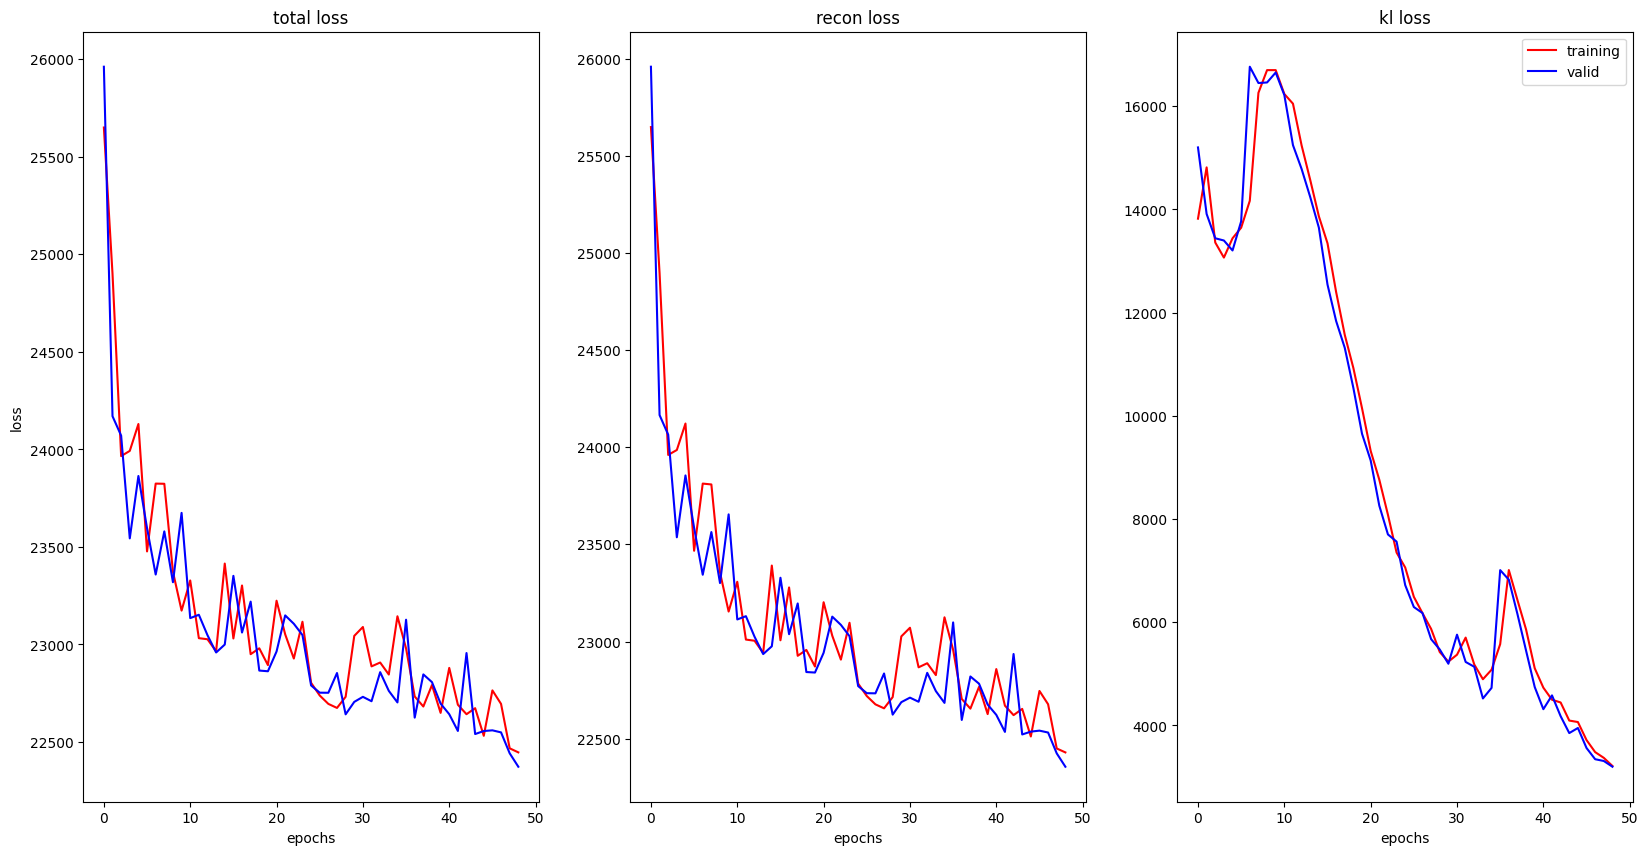

In [8]:
labels = ["total", "recon", "kl"]
colors = ["red", "blue"]

fig,arr = plt.subplots(1,3,figsize=(20,10))

N = len(train_logs)
for i in range(3):
    arr[i].plot(list(range(N)), [x[i] for x in train_logs], color=colors[0], label="training")
    arr[i].plot(list(range(N)), [x[i] for x in valid_logs], color=colors[1], label="valid")
    arr[i].set_title("%s loss"%labels[i])
    arr[i].set_xlabel("epochs")
    if i == 0:
        arr[i].set_ylabel("loss")

plt.legend()
fig.show()

## Embedding space Visualizations

In [23]:
# input_dim = len(ALPHABET) * SEQ_LENGTH
input_dim = 29903 * 5
# input_dim = 29903
vae_model = VAE(input_dim=input_dim, latent_dim=50).to(DEVICE)
vae_model.load_state_dict(torch.load("./model_saves/standard_VAE_model_BEST.pth", weights_only=True, map_location=DEVICE))
vae_model.eval()

VAE(
  (non_linear_activation): ReLU()
  (encoder): Encoder(
    (non_linear_activation): ReLU()
    (encode): Sequential(
      (0): Linear(in_features=149515, out_features=512, bias=True)
      (1): ReLU()
      (2): Linear(in_features=512, out_features=256, bias=True)
      (3): ReLU()
    )
    (fc_mean): Linear(in_features=256, out_features=50, bias=True)
    (fc_logvar): Linear(in_features=256, out_features=50, bias=True)
  )
  (decoder): Decoder(
    (non_linear_activation): ReLU()
    (means): ModuleList(
      (0): Linear(in_features=50, out_features=256, bias=True)
      (1): Linear(in_features=256, out_features=512, bias=True)
      (2): Linear(in_features=512, out_features=149515, bias=True)
    )
  )
)

In [24]:
dset = "valid"

abspath = ".."
dataset = DNADataset(f"{abspath}/data/{dset}/{dset}_aligned.fasta")
new_dataset = np.array([dataset[x][0].numpy() for x in range(len(dataset))])
# labeling
metadata = pd.read_csv(f"{abspath}/data/{dset}/{dset}_metadata.tsv", sep="\t")
vals = []
with open(f"{abspath}/data/{dset}/{dset}_aligned.fasta", "r") as f:
  doc = f.readlines()
  for d in doc:
    if ">" == d[0]:
      vals.append(d[1:])
vals = [x.strip() for x in vals]
clade_labels = [metadata.loc[metadata.strain == vals[i], "Nextstrain_clade"].values[0] for i in range(len(vals))]

In [25]:
good_clade_labels = []
for c in clade_labels:
    if len(metadata[metadata.Nextstrain_clade == c]) > 5:
        good_clade_labels.append(c)
print(set(good_clade_labels))

{'22D (Omicron)', '22A (Omicron)', '22F (Omicron)', '22B (Omicron)', '21L (Omicron)'}


In [26]:
# print(set(clade_labels))

clusters = np.array(list(set(good_clade_labels)))
print(clusters)
get_clade = lambda x: [True if elem == x else False for elem in clade_labels]

indexes = tuple([np.arange(len(clade_labels))[get_clade(x)] for x in clusters])

['22D (Omicron)' '22A (Omicron)' '22F (Omicron)' '22B (Omicron)'
 '21L (Omicron)']


In [27]:
vals = np.array(vals)

(102, 149515)
[0.92864525 0.04451635]
total variance: 0.9731615999638302


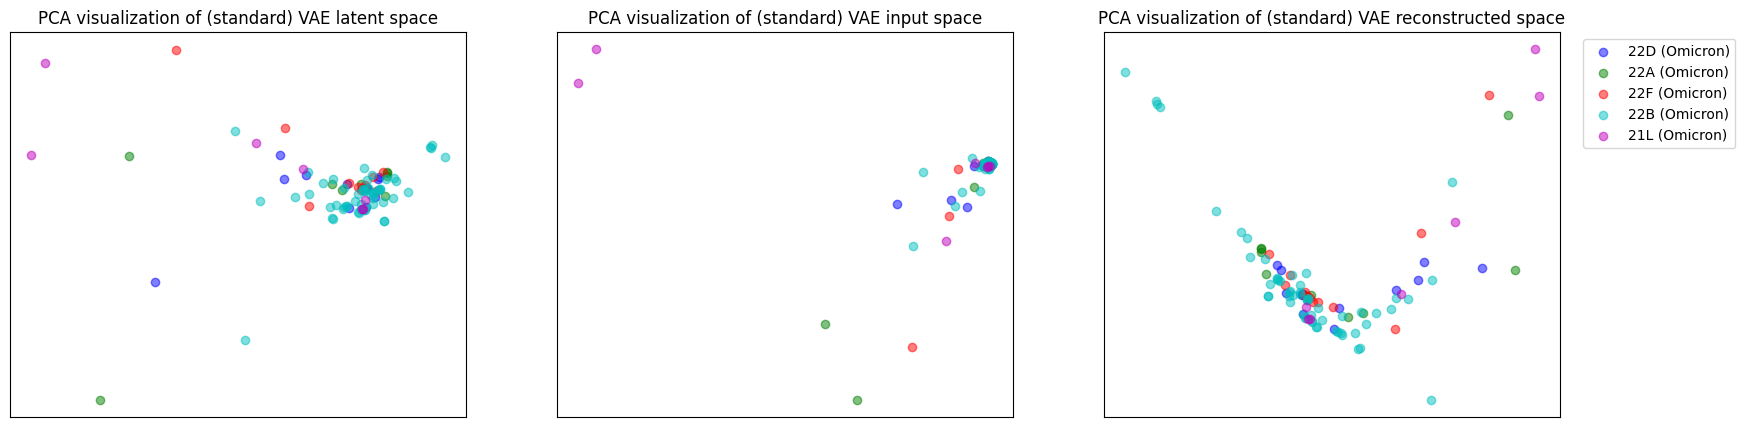

In [28]:
import matplotlib.colors as mcolors
colors = list(mcolors.BASE_COLORS.keys())
ranges = np.concatenate(indexes)

X = torch.tensor(new_dataset[ranges,:,:])
# X = X.to(DEVICE)
X = X.view(X.size(0), -1).to(DEVICE)
pca = PCA(n_components=2, svd_solver="full")

fig,ax = plt.subplots(1,3,figsize=(20,5))
for a in ax:
    a.set_xticks([])
    a.set_yticks([])
    a.axis("on")

recon = None

with torch.no_grad():
    Z_mean, Z_logvar = vae_model.encoder.forward(X)
    Z_mean = Z_mean.cpu()
    Z_std = torch.exp(0.5 * Z_logvar).cpu()
    recon = vae_model.decoder.forward(Z_mean.to(DEVICE)).cpu().numpy()
    print(recon.shape)
    
    # Z_embedded = tsne(n_components=2, learning_rate='auto', init='random', perplexity=3).fit_transform(X = Z_mean)
    pca.fit(Z_mean)
    Z_embedded = pca.transform(Z_mean)
    variances = pca.explained_variance_ratio_
    tot = np.sum(variances)
    print(variances)
    print(f"total variance: {tot}")
    curr = 0
    for i,arr in enumerate(indexes):
        loc_arr = list(range(curr,curr + len(arr),1))
        # print(set([clade_labels[x] for x in ranges[loc_arr]]))
        ax[0].scatter(Z_embedded[loc_arr,0], Z_embedded[loc_arr,1], label=clade_labels[arr[0]], alpha=0.5, color=colors[i])
        curr += len(arr)

l1 = 0.2
l2 = 0
ax[0].set_title("PCA visualization of (standard) VAE latent space")
# ax[0].legend(bbox_to_anchor=(l1,l2,l1+1,l2+1))

ax[1].set_title("PCA visualization of (standard) VAE input space")
pca = PCA(n_components=2)
X_embedded = PCA().fit_transform(X=X.cpu().numpy())
curr = 0
for i,arr in enumerate(indexes):
    loc_arr = list(range(curr,curr + len(arr),1))
    ax[1].scatter(X_embedded[loc_arr,0], X_embedded[loc_arr,1], label=clade_labels[arr[0]], alpha=0.5, color=colors[i])
    curr += len(arr)

ax[2].set_title("PCA visualization of (standard) VAE reconstructed space")
pca = PCA(n_components=2)
recon_embedded = PCA().fit_transform(X=recon)
curr = 0
for i,arr in enumerate(indexes):
    loc_arr = list(range(curr,curr + len(arr),1))
    ax[2].scatter(recon_embedded[loc_arr,0], recon_embedded[loc_arr,1], label=clade_labels[arr[0]], alpha=0.5, color=colors[i])
    curr += len(arr)
ax[2].legend(bbox_to_anchor=(l1,l2,l1+1,l2+1)) 
plt.show()

In [29]:
dset = "valid"

abspath = ".."
dataset = DNADataset(f"{abspath}/data/{dset}/{dset}_aligned.fasta")
new_dataset = np.array([dataset[x][0].numpy() for x in range(len(dataset))])

X = torch.tensor(new_dataset)
X_in = X.view(X.size(0), -1).to(DEVICE)
Z_mean, Z_logvar = vae_model.encoder.forward(X_in)

genome = np.matmul(X.numpy(), np.array([1,2,3,4,5]))
print(X.size(1))
print(genome.shape[1])
hamming_dists = []
euclid_dists = []

for i in range(X.size(0)):
    for j in range(i+1, X.size(0)):
        ham_d = np.sum(np.not_equal(genome[i,:],genome[j,:]))
        euclid_d = torch.norm(Z_mean[i,:] - Z_mean[j,:]).cpu().detach()
        hamming_dists.append(ham_d)
        euclid_dists.append(euclid_d)



29903
29903


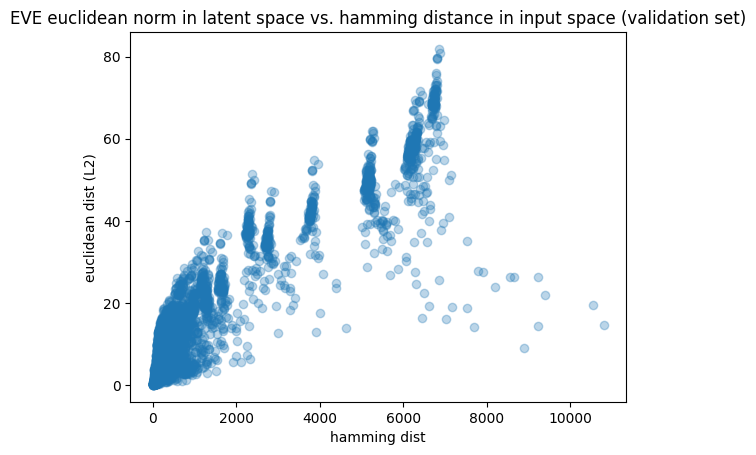

In [30]:
plt.scatter(hamming_dists, euclid_dists, alpha=0.3)
plt.title("EVE euclidean norm in latent space vs. hamming distance in input space (validation set)")
plt.xlabel("hamming dist")
plt.ylabel("euclidean dist (L2)")
plt.show()

In [31]:
print(np.corrcoef(np.vstack((euclid_dists, hamming_dists)))[1,0])

0.9222016379325774
